# FCM-based Cognitive Multi-Agent Architecture for Safety-Oriented Organizational Simulation
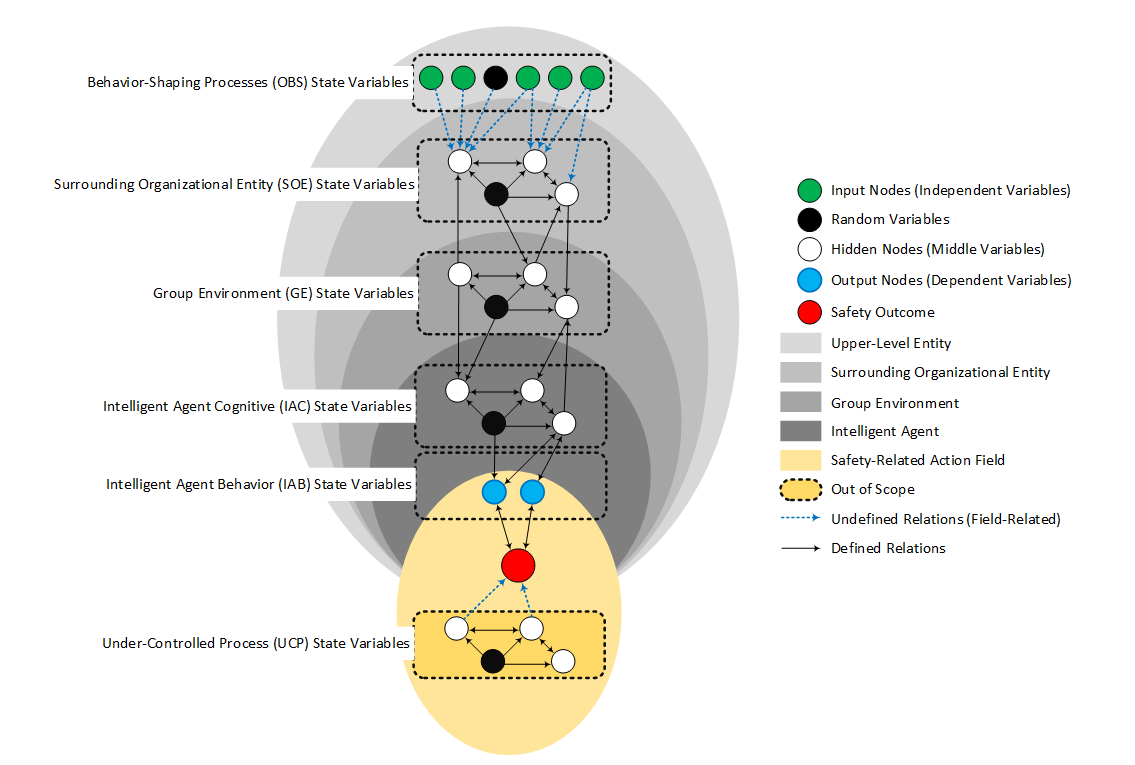

# Making Graphs from Excel Files

In [1]:
! pip install openpyxl

Saving agent_graph.xlsx to agent_graph.xlsx
Saving Agent_Group_graph.xlsx to Agent_Group_graph.xlsx
Saving Agent_SOE_graph.xlsx to Agent_SOE_graph.xlsx
Saving BSF_graph.xlsx to BSF_graph.xlsx
Saving BSF_linkage_graph.xlsx to BSF_linkage_graph.xlsx
Saving group_graph.xlsx to group_graph.xlsx
Saving SOE_graph.xlsx to SOE_graph.xlsx
Saving SOE_Group_graph.xlsx to SOE_Group_graph.xlsx
📊 agent_graph:
  ▸ Nodes: 23
  ▸ Edges: 102
  ▸ Isolated Nodes: 0

📊 Agent_Group_graph:
  ▸ Nodes: 40
  ▸ Edges: 24
  ▸ Isolated Nodes: 16

📊 Agent_SOE_graph:
  ▸ Nodes: 39
  ▸ Edges: 20
  ▸ Isolated Nodes: 12

📊 BSF_graph:
  ▸ Nodes: 70
  ▸ Edges: 0
  ▸ Isolated Nodes: 70

📊 BSF_linkage_graph:
  ▸ Nodes: 104
  ▸ Edges: 731
  ▸ Isolated Nodes: 0

📊 group_graph:
  ▸ Nodes: 17
  ▸ Edges: 21
  ▸ Isolated Nodes: 1

📊 SOE_graph:
  ▸ Nodes: 16
  ▸ Edges: 16
  ▸ Isolated Nodes: 3

📊 SOE_Group_graph:
  ▸ Nodes: 33
  ▸ Edges: 19
  ▸ Isolated Nodes: 11

📊 ✅ Combined Graph:
  ▸ Nodes: 126
  ▸ Edges: 933
  ▸ Isolated Nod

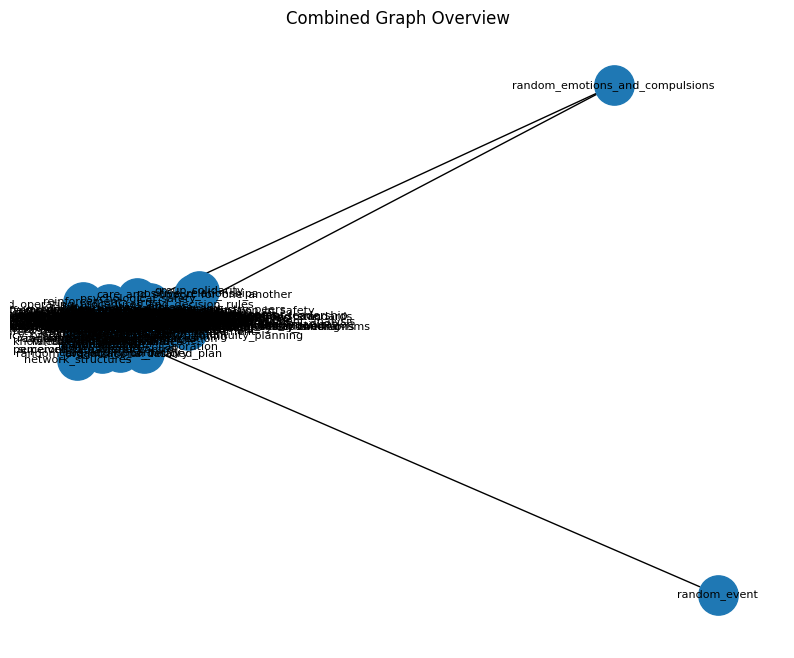

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from google.colab import files
import io
import unicodedata
import re
from collections import defaultdict

# ✅ Cleaning function
def clean_node_name(name):
    if not isinstance(name, str):
        name = str(name)
    name = unicodedata.normalize("NFKD", name)
    name = re.sub(r'[\u200b-\u200f\u202a-\u202e\u00a0]', '', name)
    name = name.strip().lower().replace(" ", "_").replace("-", "_")
    name = re.sub(r'_+', '_', name)
    return name

# ✅ Load graph from Excel adjacency matrix
def load_graph_from_excel(file):
    df = pd.read_excel(file)
    df.columns = df.columns.str.strip()
    df[df.columns[0]] = df[df.columns[0]].astype(str).str.strip()

    row_labels = df[df.columns[0]].apply(clean_node_name)
    col_labels = df.columns[1:].map(clean_node_name)

    G = nx.DiGraph()
    all_nodes = set(row_labels).union(set(col_labels))
    G.add_nodes_from(all_nodes)

    for i, target in enumerate(row_labels):
        for j, source in enumerate(col_labels):
            weight = df.iloc[i, j + 1]
            if pd.notna(weight) and weight != 0:
                G.add_edge(source, target, weight=weight)
    return G

# ✅ Graph summary function
def summarize_graph(g, name="Graph"):
    print(f"📊 {name}:")
    print(f"  ▸ Nodes: {g.number_of_nodes()}")
    print(f"  ▸ Edges: {g.number_of_edges()}")
    print(f"  ▸ Isolated Nodes: {len(list(nx.isolates(g)))}\n")

# ✅ Upload files
uploaded = files.upload()

# ✅ Load each graph, create variable with exact name (from filename without extension)
named_graphs = {}
for fname in uploaded:
    base_name = re.sub(r'\s*\(\d+\)$', '', fname.replace(".xlsx", "").strip())
    with io.BytesIO(uploaded[fname]) as f:
        G = load_graph_from_excel(f)
        named_graphs[base_name] = G
        globals()[base_name] = G  # Create variable with exact name
        summarize_graph(G, name=base_name)

# ✅ Combine into one full graph
combined_graph = nx.DiGraph()
for g in named_graphs.values():
    combined_graph = nx.compose(combined_graph, g)

summarize_graph(combined_graph, name="✅ Combined Graph")

# ✅ Detect duplicates
raw_nodes = list(combined_graph.nodes())
node_dict = defaultdict(list)
for n in raw_nodes:
    normalized = clean_node_name(n)
    node_dict[normalized].append(n)

print("🔍 Potential duplicate nodes (same normalized name but different original forms):\n")
for norm, variants in node_dict.items():
    if len(variants) > 1:
        print(f"→ '{norm}': {variants}")

# ✅ Optional quick view
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(combined_graph, seed=42)
nx.draw_networkx(combined_graph, pos, with_labels=True, node_size=800, font_size=8, arrows=True)
plt.title("Combined Graph Overview")
plt.axis('off')
plt.show()


# ALL VARIABLES GRAPH
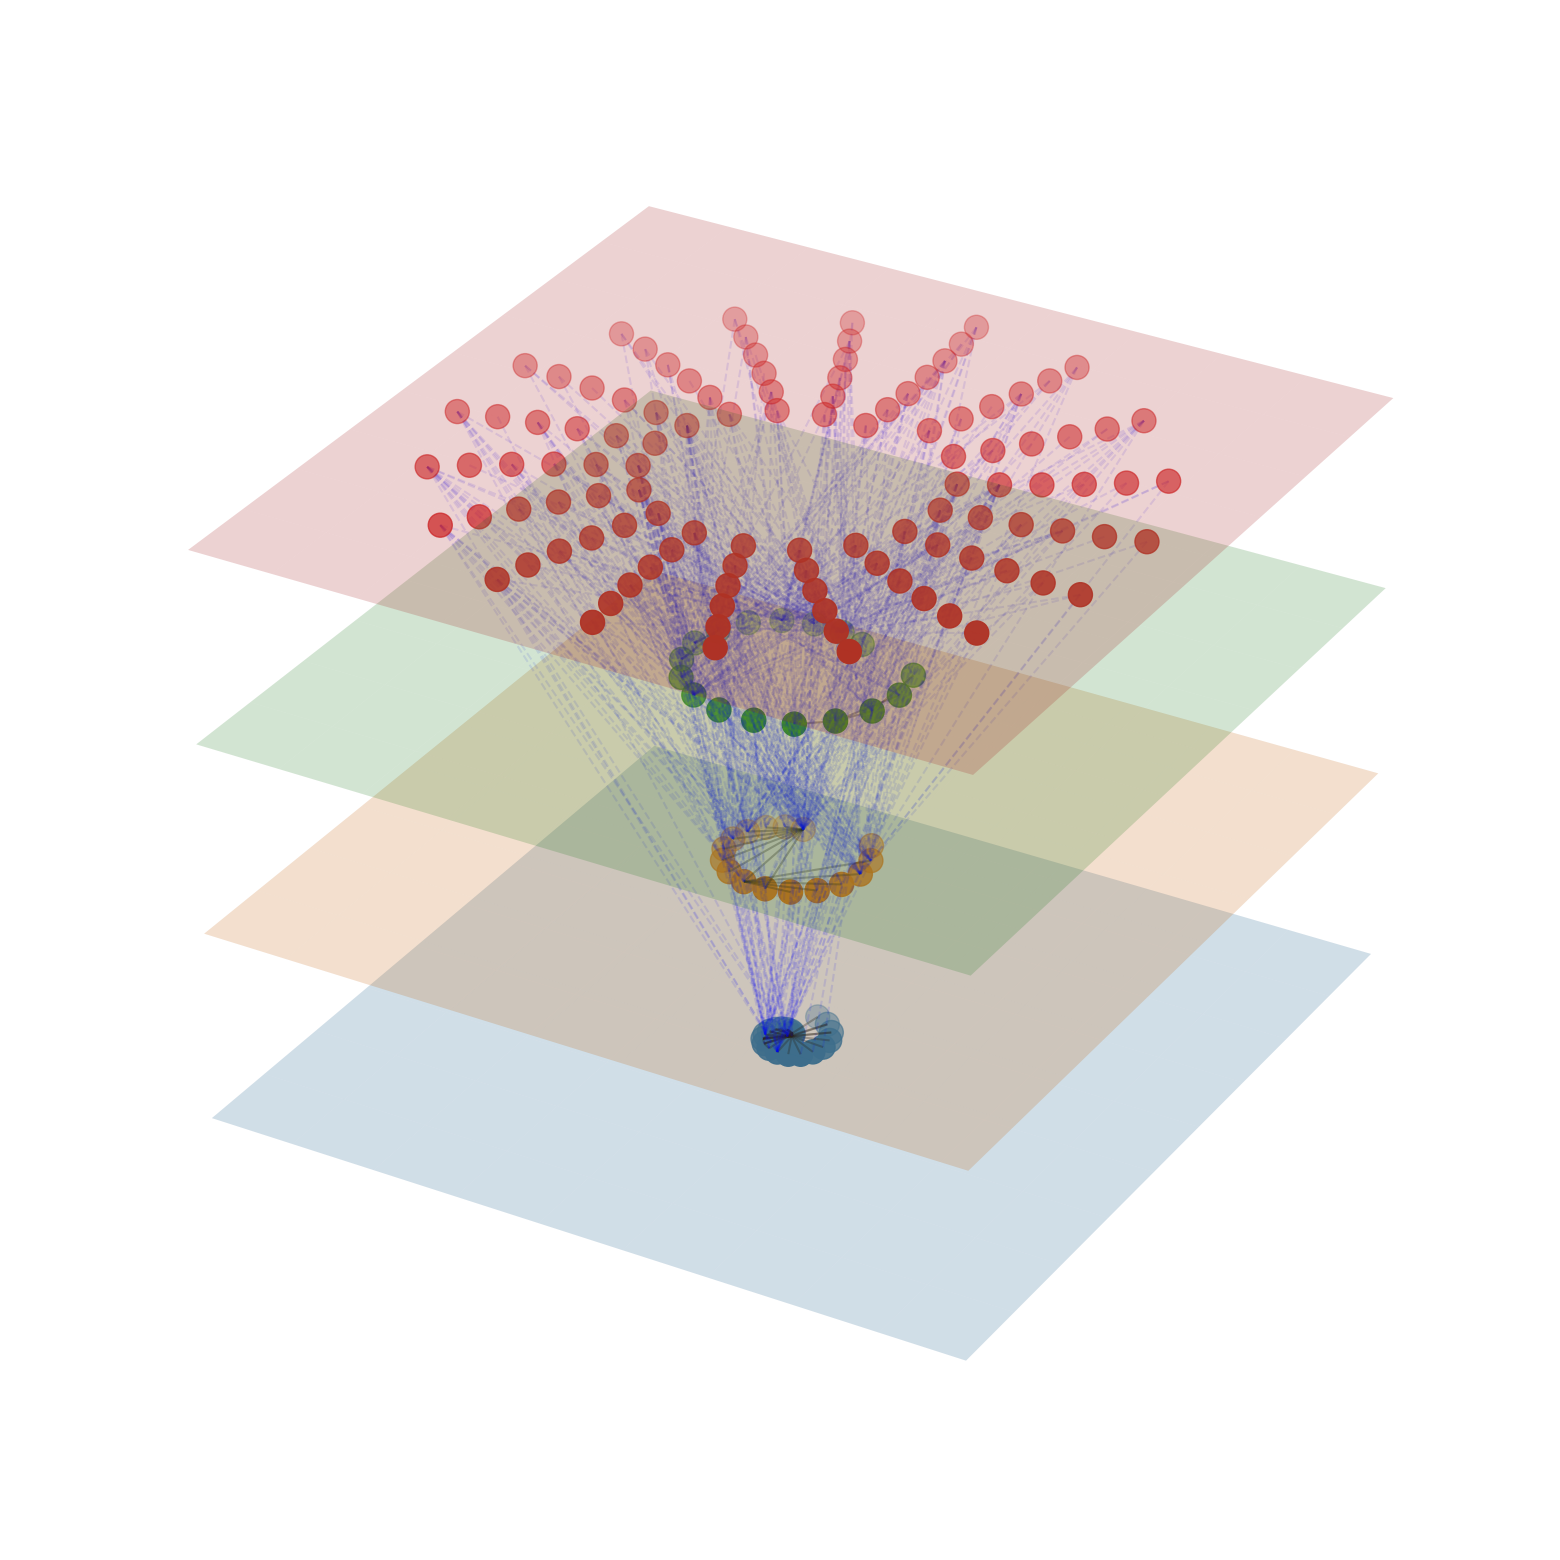

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

class LayeredNetworkGraph(object):
    def __init__(self, graph, subgraph_nodes_list, cross_relation_graphs, node_labels=None,
                 layout=nx.spring_layout, ax=None, layer_distance=1,
                 behavioral_nodes=None, bsp_nodes=None):
        self.graph = graph
        self.subgraph_nodes_list = subgraph_nodes_list
        self.cross_relation_graphs = cross_relation_graphs
        self.total_layers = len(subgraph_nodes_list)

        self.node_labels = node_labels
        self.layout = layout
        self.layer_distance = layer_distance
        self.bsp_nodes = bsp_nodes if bsp_nodes else []

        if ax:
            self.ax = ax
        else:
            fig = plt.figure(figsize=(10, 10))
            self.ax = fig.add_subplot(111, projection='3d')

        self.node_positions = {}

        self._get_nodes()
        self._get_node_positions()
        self._get_edges_within_layers()
        self._get_edges_cross_relations()
        self._draw()

    def _get_nodes(self):
        self.nodes = []
        for z, sub_nodes in enumerate(self.subgraph_nodes_list):
            self.nodes.extend([(node, z) for node in sub_nodes])

    def _get_edges_within_layers(self):
        self.edges_within_layers = []
        for z, sub_nodes in enumerate(self.subgraph_nodes_list):
            subgraph = self.graph.subgraph(sub_nodes)
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in subgraph.edges()])

    def _get_edges_cross_relations(self):
        self.edges_cross_relations = []
        for relation_name, graph in self.cross_relation_graphs.items():
            for source, target in graph.edges():
                src_layer = self._find_node_layer(source)
                tgt_layer = self._find_node_layer(target)
                if (source, src_layer) in self.node_positions and (target, tgt_layer) in self.node_positions:
                    self.edges_cross_relations.append(((source, src_layer), (target, tgt_layer)))
                else:
                    print(f"Warning: Node position for {(source, src_layer)} or {(target, tgt_layer)} in {relation_name} not found.")

    def _find_node_layer(self, node):
        for z, sub_nodes in enumerate(self.subgraph_nodes_list):
            if node in sub_nodes:
                return z
        return None

    def _get_node_positions(self, *args, **kwargs):
        pos = self.layout(self.graph, *args, **kwargs)
        self.node_positions = dict()
        for z, sub_nodes in enumerate(self.subgraph_nodes_list):
            self.node_positions.update({(node, z): (*pos[node], z * self.layer_distance) for node in sub_nodes})

    def _draw_nodes(self, nodes, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        facecolors = []
        edgecolors = []
        sizes = []

        for node in nodes:
            node_key = node[0]
            label = node_key.lower()

            if 'random_' in label:
                facecolors.append('black')
                edgecolors.append('black')
                sizes.append(150)
            elif label == 'safety_outcome':
                facecolors.append('red')
                edgecolors.append('red')
                sizes.append(600)
            elif label == 'behavior':
                facecolors.append('blue')
                edgecolors.append('blue')
                sizes.append(300)
            elif node_key in self.bsp_nodes:
                facecolors.append('green')
                edgecolors.append('green')
                sizes.append(300)
            else:
                facecolors.append('white')
                edgecolors.append('black')
                sizes.append(300)

        self.ax.scatter(x, y, z, s=sizes, facecolors=facecolors, edgecolors=edgecolors,
                        linewidths=1.5, alpha=1.0, *args, **kwargs)

    def _draw_edges(self, edges, *args, **kwargs):
        segments = [(self.node_positions[source], self.node_positions[target]) for source, target in edges]
        line_collection = Line3DCollection(segments, linewidths=0.5, *args, **kwargs)
        self.ax.add_collection3d(line_collection)

    def _get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), (ymin - pad * dy, ymax + pad * dy)

    def _draw_plane(self, z, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self._get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u, v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, *args, **kwargs)

    def _draw_node_labels(self, node_labels, *args, **kwargs):
        for node, z in self.nodes:
            if node in node_labels:
                self.ax.text(*self.node_positions[(node, z)], node_labels[node], *args, **kwargs)

    def _draw(self):
        self._draw_edges(self.edges_within_layers, color='k', alpha=0.7, linestyle='-', zorder=5)
        self._draw_edges(self.edges_cross_relations, color='b', alpha=0.5, linestyle='--', zorder=5)

        layer_titles = {
            0: 'Agent Level',
            1: 'Group Level',
            2: 'SOE',
            3: 'BSMs'
        }

        for z in range(self.total_layers):
            self._draw_plane(z, alpha=0.2, zorder=1)
            layer_nodes = [node for node in self.nodes if node[1] == z]
            self._draw_nodes(layer_nodes, zorder=3)

            (xmin, xmax), (ymin, ymax) = self._get_extent(pad=0.1)
            x_text = xmax - 0.4
            y_text = ymax - 0.4
            self.ax.text(x_text, y_text, z * self.layer_distance + 0.1,
                        layer_titles[z], fontsize=25, color='black',
                        horizontalalignment='left')


        if self.node_labels:
            self._draw_node_labels(self.node_labels,
                                   horizontalalignment='center',
                                   verticalalignment='center',
                                   zorder=100)


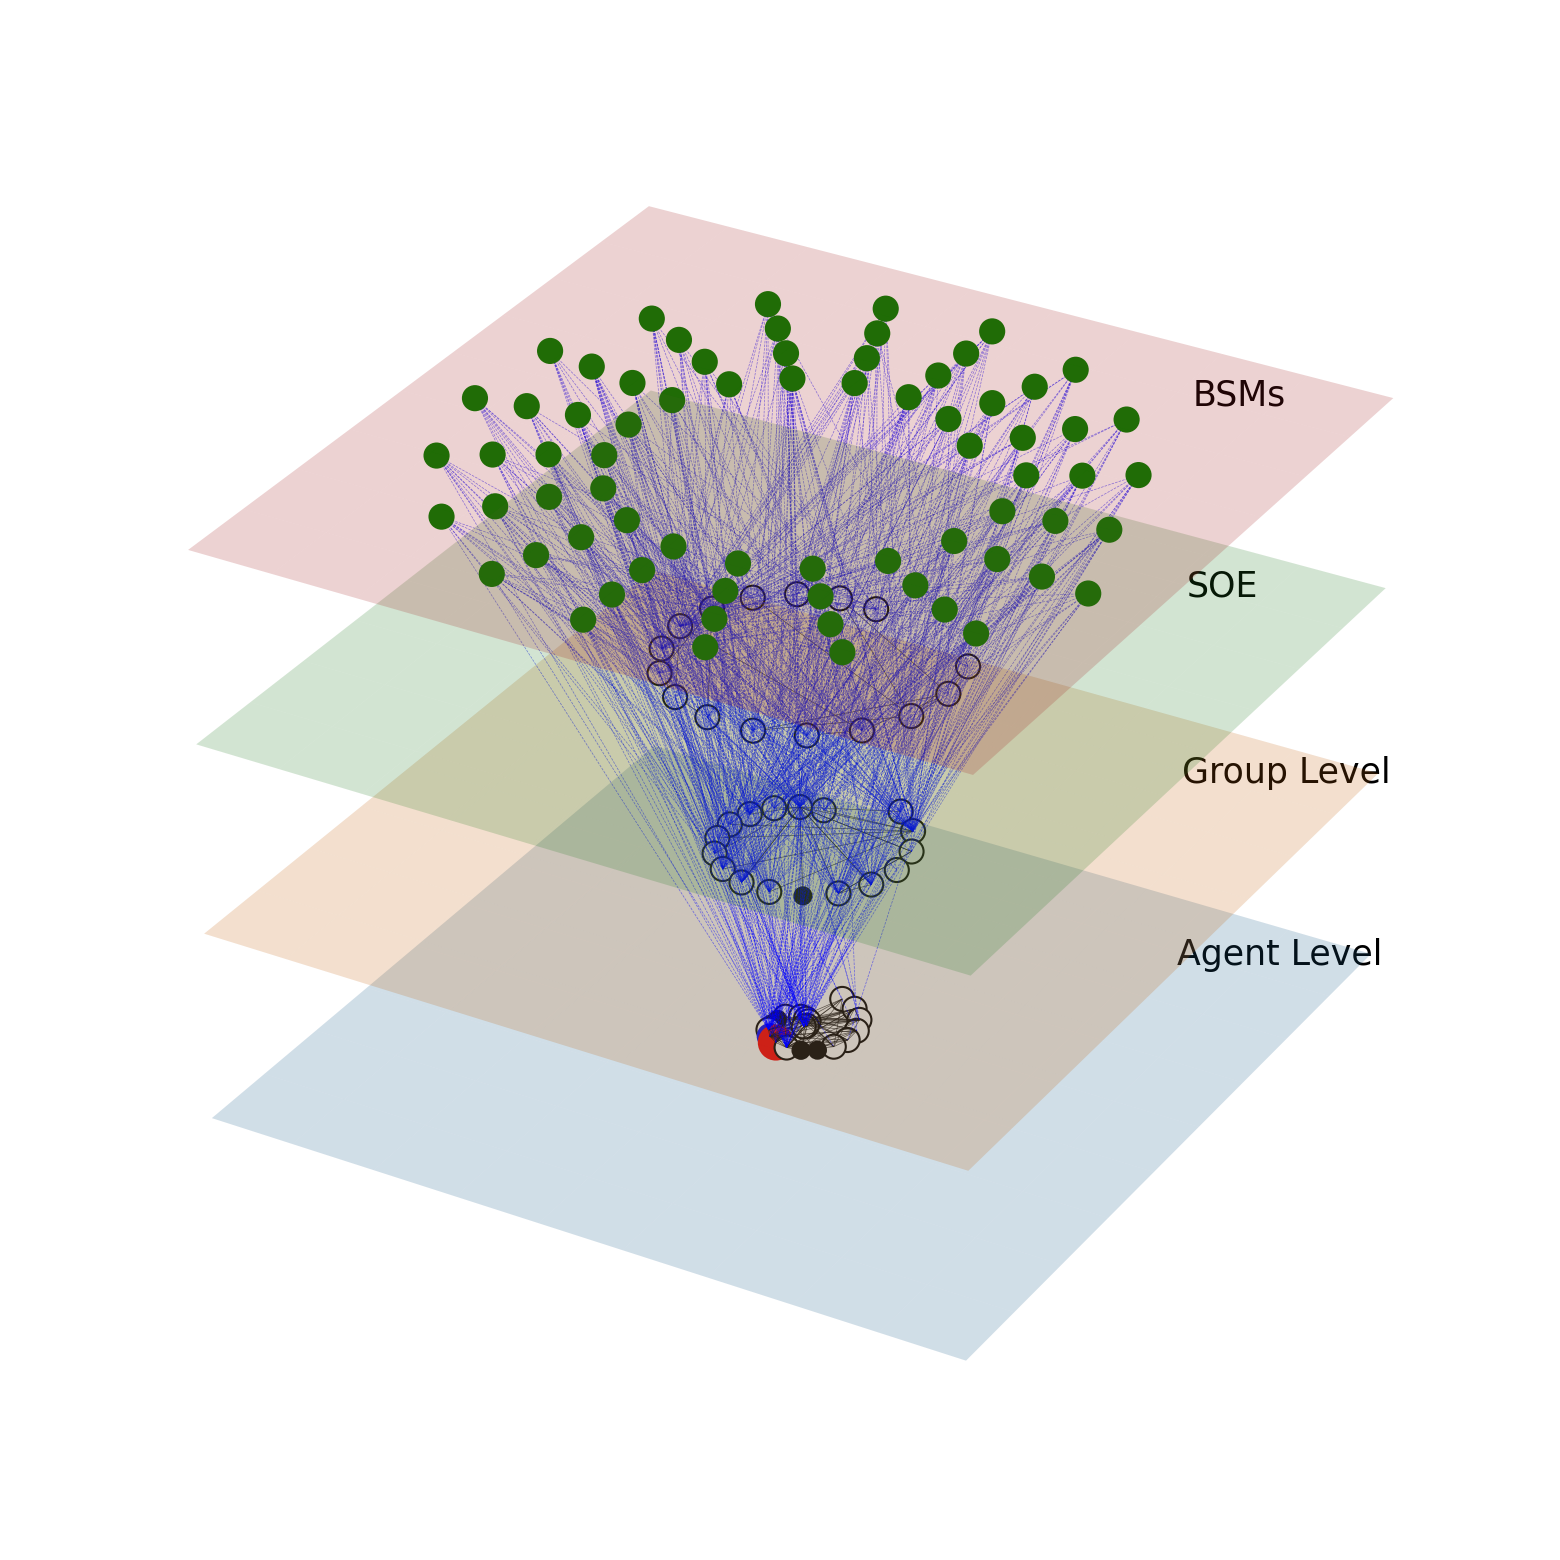

In [12]:
if __name__ == '__main__':
    # Main graph
    G = combined_graph

    # Define subgraphs by node name
    subgraph_nodes_list = [
        list(agent_graph.nodes()),                     # Layer 0 - Agent Level
        list(group_graph.nodes()),                     # Layer 1 - Group Level
        list(SOE_graph.nodes()),                       # Layer 2 - Surrounding Organizational Environment
        list(BSF_graph.nodes())                        # Layer 3 - Behavior-Shaping Mechanisms
    ]


    # Cross-relation graphs dictionary
    cross_relation_graphs = {
        'Agent_Group_graph': Agent_Group_graph,
        'Agent_SOE_graph': Agent_SOE_graph,
        'SOE_Group_graph': SOE_Group_graph,
        'BSF_linkage_graph': BSF_linkage_graph
    }


    bsp_nodes = list(BSF_graph.nodes())

    # Initialize figure and plot
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    LayeredNetworkGraph(
        G,
        subgraph_nodes_list,
        cross_relation_graphs,
        node_labels=None,
        ax=ax,
        layout=nx.spiral_layout,
        layer_distance=1,
        bsp_nodes=bsp_nodes
    )

    ax.set_axis_off()
    plt.show()


# Developing MAS Structure

**Storing the MAS Structure to a Dataframe (MAS_df)**

In [ ]:
import pandas as pd

# Create a Global Variable to save Data
MAS_df = pd.DataFrame(columns=['SOE', 'Group', 'Agent'])

# Function to Fill Dataframe
def add_row_to_dataframe(soe, group, agent, dataframe):
    new_row = pd.DataFrame({'SOE': [soe], 'Group': [group], 'Agent': [agent]})
    dataframe = pd.concat([dataframe, new_row], ignore_index=True)
    return dataframe

# Main Function to get Data
def main():
    global MAS_df
    while True:
        # Ask for the Department Name (SOE)
        SOE_Name = input("Enter the Name of Organizational Environment (or Department): ")

        # Ask for the Unit Name (Group)
        Group_Name = input("Enter the Name of Group (or unit): ")

        # Ask for the number of agents for this Unit (or group)
        num_agents = int(input(f"Enter the number of agents for group {Group_Name}: "))

        # Update the MAS DataFrame
        MAS_df = add_row_to_dataframe(SOE_Name, Group_Name, num_agents, MAS_df)

        # Ask to continue Designing Process
        Resp = input("Is the Designing Process Finished? (Yes or No) ")
        if Resp.lower() == 'yes':
            break

# Run the main function
main()

# Display the final DataFrame
print(MAS_df)


Enter the Name of Organizational Environment (or Department): Safety_Dpt
Enter the Name of Group (or unit): Aviation_Safety_Unit
Enter the number of agents for group Aviation_Safety_Unit: 2
Is the Designing Process Finished? (Yes or No) No
Enter the Name of Organizational Environment (or Department): Safety_Dpt
Enter the Name of Group (or unit): Safety_Assurance_Unit
Enter the number of agents for group Safety_Assurance_Unit: 3
Is the Designing Process Finished? (Yes or No) No
Enter the Name of Organizational Environment (or Department): Safety_Dpt
Enter the Name of Group (or unit): Industrial_Safety_Unit
Enter the number of agents for group Industrial_Safety_Unit: 3
Is the Designing Process Finished? (Yes or No) Yes
          SOE                   Group Agent
0  Safety_Dpt    Aviation_Safety_Unit     2
1  Safety_Dpt   Safety_Assurance_Unit     3
2  Safety_Dpt  Industrial_Safety_Unit     3


**Developing the Network based on MAS structure**

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image

# Initialize networkx graph
all_network = nx.DiGraph()

# Function to add nodes and edges to the networkx graph
def add_edges(nx_graph, source_graph, prefix, iteration, labeled=True):
    # Change label and name of nodes based on their belonging
    for edge in source_graph.edges(data=True):
        source_label = f"{prefix}_{edge[0]}_{iteration}" if labeled else edge[0]
        target_label = f"{prefix}_{edge[1]}_{iteration}" if labeled else edge[1]
        source_name = edge[0]
        target_name = edge[1]

        if source_label not in nx_graph:
            nx_graph.add_node(source_label, label=source_label, name=source_name, size=10)
        if target_label not in nx_graph:
            nx_graph.add_node(target_label, label=target_label, name=target_name, size=10)

        nx_graph.add_edge(source_label, target_label, weight=edge[2]['weight'])

    return nx_graph

# Function to add group_nodes and edges to the networkx graph
def group_add_edges(nx_graph, source_graph, prefix, iteration, labeled=True):
    for edge in source_graph.edges(data=True):
        source_label = f"{prefix}_{edge[0]}_{iteration}" if labeled else edge[0]
        target_label = f"{prefix}_{edge[1]}_{iteration}" if labeled else edge[1]
        source_name = f"{prefix}_{edge[0]}" if labeled else edge[0]
        target_name = f"{prefix}_{edge[1]}" if labeled else edge[1]

        if source_label not in nx_graph:
            nx_graph.add_node(source_label, label=source_label, name=source_name, size=10)
        if target_label not in nx_graph:
            nx_graph.add_node(target_label, label=target_label, name=target_name, size=10)

        nx_graph.add_edge(source_label, target_label, weight=edge[2]['weight'])

    return nx_graph


# Iterate through MAS_df rows
for idx, row in MAS_df.iterrows():
    group = row['Group']
    agent_count = row['Agent']

    # Generate agent-networks
    for i in range(agent_count):
        all_network = add_edges(all_network, agent_graph, group, i, labeled=True)
        all_network = group_add_edges(all_network, group_graph, group, i, labeled=True)
        all_network = add_edges(all_network, SOE_graph, group, i, labeled=True)
        all_network = add_edges(all_network, Agent_Group_graph, group, i, labeled=True)
        all_network = add_edges(all_network, Agent_SOE_graph, group, i, labeled=True)
        all_network = add_edges(all_network, SOE_Group_graph, group, i, labeled=True)
        all_network = add_edges(all_network, BSF_graph, group, i, labeled=True)
        all_network = add_edges(all_network, BSF_linkage_graph, group, i, labeled=True)

    # Display iteration details
    print(f"Iteration {idx + 1}: Nodes = {len(all_network.nodes())}, Edges = {len(all_network.edges())}")
    for node in all_network.nodes(data=True):
        print(f"Node: {node[1]['name']} : {node[1]['label']}")



Iteration 1: Nodes = 252, Edges = 1866
Node: normative_belief : Aviation_Safety_Unit_normative_belief_0
Node: intention : Aviation_Safety_Unit_intention_0
Node: reason_for : Aviation_Safety_Unit_reason_for_0
Node: subjective_norms : Aviation_Safety_Unit_subjective_norms_0
Node: knowledge_skills_and_abilities : Aviation_Safety_Unit_knowledge_skills_and_abilities_0
Node: behavior : Aviation_Safety_Unit_behavior_0
Node: commitment_to_safety : Aviation_Safety_Unit_commitment_to_safety_0
Node: reason_against : Aviation_Safety_Unit_reason_against_0
Node: values_and_beliefs : Aviation_Safety_Unit_values_and_beliefs_0
Node: perceived_behavioral_control : Aviation_Safety_Unit_perceived_behavioral_control_0
Node: random_emotions_and_compulsions : Aviation_Safety_Unit_random_emotions_and_compulsions_0
Node: belief_strength : Aviation_Safety_Unit_belief_strength_0
Node: random_power_of_will : Aviation_Safety_Unit_random_power_of_will_0
Node: attitude : Aviation_Safety_Unit_attitude_0
Node: control

**Merging redundant nodes and edges**

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# List of node names to merge (For BSF and SOE nodes)
merge_list = list(BSF_graph.nodes())
merge_list.extend(SOE_graph.nodes())

# Function to create similar group nodes
def find_similar_group_nodes(data_frame, graph):
    group_nodes = list(graph.nodes())
    group_merged_list = []
    for idx, row in data_frame.iterrows():
        group = row[1]
        agent_num = row[2]
        if agent_num > 1:
            for group_node in group_nodes:
                target_node = f"{group}_{group_node}"
                group_merged_list.append(target_node)
    return group_merged_list

def merge_nodes(graph, merge_list, weight_name="weight"):
    """Merges nodes and keeps the original weight of duplicate edges."""
    for name in merge_list:
        print(f"----------name in merge_list----------------------------------------{name}")
        nodes_to_merge = [node for node, data in graph.nodes(data=True) if data.get('name') == name]
        print(f" similar nodes..............{nodes_to_merge}")
        while len(nodes_to_merge) > 1:
            main_node = nodes_to_merge[0]
            print(f"...Main Node....{main_node}")
            merge_node = nodes_to_merge[1]
            print(f"...Merged Node....{merge_node}")

            for node, data in list(graph.nodes(data=True)):
                #node_name = data.get('name') #target node
                #print(f"Selected Node: {node}")
                if node != main_node and node != merge_node and (graph.has_edge(merge_node,  node) or graph.has_edge(node,  merge_node)):
                  print(f"-----------------------------the linked node is finded-----:Linked Node: {node}")
                  if graph.has_edge(node,  merge_node):
                    graph.remove_edge(node,  merge_node)
                    if not graph.has_edge(node,  main_node):
                      graph.add_edge(node, main_node, **data)

                  if graph.has_edge(merge_node,  node):
                    graph.remove_edge(merge_node,  node)
                    if not graph.has_edge(main_node,  node):
                      graph.add_edge(main_node,  node, **data)
            isolated_nodes =[]
            isolated_nodes = [node for node in graph.nodes() if graph.degree(node) == 0]
            graph.remove_nodes_from(isolated_nodes)
            print(isolated_nodes)
            if len(isolated_nodes)== 0:
              print("ERROR!!")
              return

            nodes_to_merge = [node for node, data in graph.nodes(data=True) if data.get('name') == name]

        else:
            print(f"No need to merge nodes with name {name}, only one node found.")


group_merged_list = find_similar_group_nodes(MAS_df, group_graph)

# Merge Similar nodes based on their names (BSF and SOE)
merge_nodes(all_network, merge_list)

# Merge Similar group nodes
merge_nodes(all_network, group_merged_list)

# Printing final nodes name and label
print("Graph nodes with their names and labels:")
for node, data in all_network.nodes(data=True):
    print(f"Node: {node}, Name: {data.get('name')}, Label: {data.get('label')}")



<ipython-input-6-594895daa473>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group = row[1]
<ipython-input-6-594895daa473>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  agent_num = row[2]


Streaming output truncated to the last 5000 lines.
-----------------------------the linked node is finded-----:Linked Node: Aviation_Safety_Unit_safety_performance_metrics_and_dashboards_0
-----------------------------the linked node is finded-----:Linked Node: Aviation_Safety_Unit_assessing_and_reporting_compliance_with_safety_requirements_and_standards_0
-----------------------------the linked node is finded-----:Linked Node: Aviation_Safety_Unit_contractor_safety_management_0
-----------------------------the linked node is finded-----:Linked Node: Aviation_Safety_Unit_safety_corrective_actions_0
-----------------------------the linked node is finded-----:Linked Node: Aviation_Safety_Unit_safety_training_evaluation_and_improvement_0
-----------------------------the linked node is finded-----:Linked Node: Aviation_Safety_Unit_safety_resource_allocation_0
-----------------------------the linked node is finded-----:Linked Node: Aviation_Safety_Unit_utilizing_field_data_in_safety_decisio

In [ ]:
import networkx as nx

# Assuming all_network is your graph
node_count = len(all_network.nodes())
print(f"The number of nodes in all_network: {node_count}")


The number of nodes in all_network: 326


**Check Multiple Incoming Edges**

In [ ]:
import networkx as nx
from collections import defaultdict

# Assuming all_network is your graph
def find_nodes_with_multiple_incoming_edges(graph):
    # Dictionary to store nodes with their incoming edges
    incoming_edges = defaultdict(list)

    # Iterate through each edge
    for source, target in graph.edges():
        incoming_edges[target].append(source)

    # List to store nodes with two or more incoming edges from the same node
    nodes_with_multiple_incoming = []

    # Check each node's incoming edges
    for target, sources in incoming_edges.items():
        # Count occurrences of each source
        source_counts = defaultdict(int)
        for source in sources:
            source_counts[source] += 1

        # Find nodes with two or more incoming edges from the same node
        for source, count in source_counts.items():
            if count >= 2:
                nodes_with_multiple_incoming.append(target)
                break

    return nodes_with_multiple_incoming

# Find nodes with multiple incoming edges from the same node
nodes_with_multiple_incoming_edges = find_nodes_with_multiple_incoming_edges(all_network)
print("Nodes with multiple incoming edges from the same node:", nodes_with_multiple_incoming_edges)


Nodes with multiple incoming edges from the same node: []


**Check Root Nodes**

In [ ]:
import networkx as nx

# Assuming all_network is your graph
num =0
for i, (node, data) in enumerate(all_network.nodes(data=True)):
    node_name = data.get('name')
    node_label = data.get('label')

    if all_network.in_degree(node) == 0 and 'Random' not in node_name:  # Check if the node has no incoming edges
        num +=1
        print(f" root nodes: {node_name}---{node_label}")

print(f" number of root nodes: {num}")


 root nodes: random_emotions_and_compulsions---Aviation_Safety_Unit_random_emotions_and_compulsions_0
 root nodes: random_power_of_will---Aviation_Safety_Unit_random_power_of_will_0
 root nodes: random_individual_differences---Aviation_Safety_Unit_random_individual_differences_0
 root nodes: random_event---Aviation_Safety_Unit_random_event_0
 root nodes: random_identity_and_role---Aviation_Safety_Unit_random_identity_and_role_0
 root nodes: random_self_knowledge---Aviation_Safety_Unit_random_self_knowledge_0
 root nodes: random_past_experience---Aviation_Safety_Unit_random_past_experience_0
 root nodes: Aviation_Safety_Unit_random_organizational_history---Aviation_Safety_Unit_random_organizational_history_0
 root nodes: safety_management_system---Aviation_Safety_Unit_safety_management_system_0
 root nodes: safety_training_ensurance---Aviation_Safety_Unit_safety_training_ensurance_0
 root nodes: worker_safety_involvement_programs---Aviation_Safety_Unit_worker_safety_involvement_programs

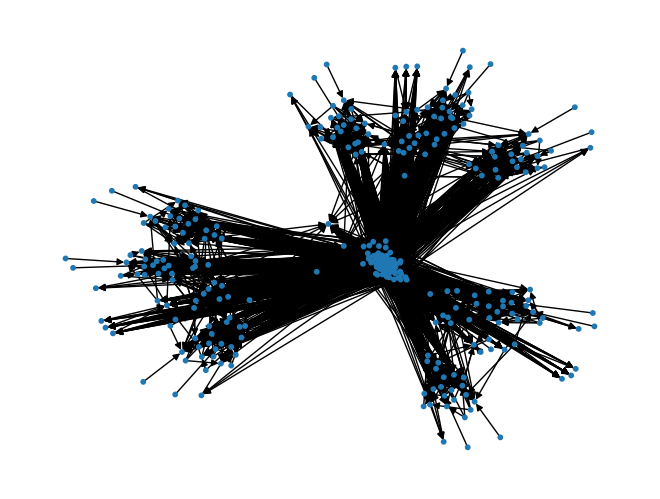

<Figure size 3000x2000 with 0 Axes>

In [ ]:
# Plotting the graph using networkx and matplotlib
pos = nx.spring_layout(all_network, k=None, pos=None, fixed=None, iterations=50, threshold=0.0001, weight='weight', scale=1, center=None, dim=2, seed=None)
nx.draw(all_network, pos, with_labels=False, labels=nx.get_node_attributes(all_network, 'name'), node_size=[d.get('size', 100) for (n, d) in all_network.nodes(data=True)])
plt.figure(figsize=(30, 20))
plt.show()

# Save the Graph_structure

In [ ]:
import networkx as nx
nx.write_graphml(all_network, '/content/all_network.graphml')
print("Graph has been saved to all_network.graphml")


Graph has been saved to all_network.graphml
